# sklearn.linear_model.SGDClassifier

In [21]:
import xml.etree.ElementTree as ET
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics import accuracy_score
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as EN_STOP_WORDS
from spacy.lang.fr.stop_words import STOP_WORDS as FR_STOP_WORDS
from spacy.lang.it.stop_words import STOP_WORDS as IT_STOP_WORDS

! python3.11 -m spacy download en_core_web_sm
! python3.11 -m spacy download fr_core_news_sm
! python3.11 -m spacy download it_core_news_sm


  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
  Using cached https://github.com/explosion/spacy-models/releases/download/fr_core_news_sm-3.7.0/fr_core_news_sm-3.7.0-py3-none-any.whl (16.3 MB)

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 42.3 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
✔ Download and installation success

# XML Reading function

In [22]:

def parse_xml_to_dict(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    data_dict = {}
    for doc in root.findall('doc'):
        text_parts = []
        for p in doc.find('texte').findall('p'):
            if p.text:
                text_parts.append(p.text)
        
        text = ' '.join(text_parts)
        label = doc.find('.//PARTI').attrib['valeur']
        doc_id = doc.attrib['id']
        
        data_dict[doc_id] = (text, label)
    
    return data_dict

def lemmatize_and_remove_stopwords(text, language):
    if language == 'english':
        nlp = spacy.load('en_core_web_sm')
        stop_words = EN_STOP_WORDS
    elif language == 'french':
        nlp = spacy.load('fr_core_news_sm')
        stop_words = FR_STOP_WORDS
    elif language == 'italian':
        nlp = spacy.load('it_core_news_sm')
        stop_words = IT_STOP_WORDS
    else:
        raise ValueError("Y a pas de langue comme ça :(")

    doc = nlp(text)
    cleaned_tokens = [token.lemma_ for token in doc if token.text.lower() not in stop_words]
    cleaned_text = ' '.join(cleaned_tokens)
    return cleaned_text

def nettoyer_dicos(dico, langue):
    cleaned_dict = {}
    for doc_id, (text, label) in dico.items():
        cleaned_text = lemmatize_and_remove_stopwords(text, langue)
        cleaned_dict[doc_id] = (cleaned_text, label)
    return cleaned_dict

train_en = parse_xml_to_dict("/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/deft09_parlement_appr.xml/deft09_parlement_appr_en.xml")
train_en = nettoyer_dicos(train_en, 'english')

train_fr = parse_xml_to_dict("/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/deft09_parlement_appr.xml/deft09_parlement_appr_fr.xml")
train_fr = nettoyer_dicos(train_fr, 'french')

train_it = parse_xml_to_dict("/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/deft09_parlement_appr.xml/deft09_parlement_appr_it.xml")
train_it = nettoyer_dicos(train_it, 'italian')


In [31]:
data_train_en = np.array(list(train_en.values()))
data_train_fr = np.array(list(train_fr.values()))
data_train_it = np.array(list(train_it.values()))

clean_train_dictionary = {
    'data_train_en': data_train_en,
    'data_train_fr': data_train_fr,
    'data_train_it': data_train_it
}

clean_train_dictionary

{'data_train_en': array([["herald ' stage opening postal service competition ' , Council want European Parliament approve directive constitute step away public postal service . policy national government european institution reactionary policy harmful user worker sector , face job loss . reject Council draft text , serve interest private company share profitable sector postal service leave public sector scrap incapable properly fulfil social need . reject compromise amendment design mask hypocrisy capitulation private interest . like reiterate postal service remain public service , access condition , location social situation . - tiere postal system , private profit gain user stop opening postal service private provider . \xa0",
         'GUE-NGL'],
        ['Mr President , evening 12 August , daughter buy camera home town Döbelin , population 28 000 . hour later , shop long exist . apply 1 425 home district 711 business . course , school , scientific establishment , , public infrastru

In [32]:
import pickle

# save dictionary to person_data.pkl file
with open('clean_test_dictionary.pkl', 'wb') as fp:
    pickle.dump(clean_test_dictionary, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


# Création d'un dico TEST (données avec une structure différente)

In [33]:
def parse_xml_and_labels(xml_file, labels_file):
    test_labels_dict = {}
    with open(labels_file, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                doc_id = parts[0]
                label = parts[1]
                test_labels_dict[doc_id] = label
            #else:
                #print('There is no class label for : ', line, str(labels_file.split('.')[-2]))
    
    def parse_xml_to_dict(file_path):
        tree = ET.parse(file_path)
        root = tree.getroot()
        
        data_dict = {}
        for doc in root.findall('doc'):
            text_parts = []
            for p in doc.find('texte').findall('p'):
                if p.text:
                    text_parts.append(p.text)
            
            text = ' '.join(text_parts)
            doc_id = doc.attrib['id']
            
            data_dict[doc_id] = text
        
        return data_dict
    
    test_dict = parse_xml_to_dict(xml_file)
    final_test_data = {}
    for doc_id, text in test_dict.items():
        if doc_id in test_labels_dict:
            label = test_labels_dict[doc_id]
            final_test_data[doc_id] = (text, label)
    
    return final_test_data


In [34]:
test_en = parse_xml_and_labels("/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/deft09_parlement_test.xml/deft09_parlement_test_en.xml", "/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/deft09_parlement_ref/deft09_parlement_ref_en.txt")
len(test_en)

test_fr = parse_xml_and_labels("/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/deft09_parlement_test.xml/deft09_parlement_test_fr.xml", "/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/deft09_parlement_ref/deft09_parlement_ref_fr.txt")
len(test_fr)

test_it = parse_xml_and_labels("/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/deft09_parlement_test.xml/deft09_parlement_test_it.xml", "/Users/Michel/Desktop/TAL/MACHINE_LEARNING?/projet/deft09_parlement_ref/deft09_parlement_ref_it.txt")
len(test_it)

12915

In [78]:
data_test_en = np.array(list(test_en.values()))
data_test_fr = np.array(list(test_fr.values()))
data_test_it = np.array(list(test_it.values()))

test_dictionary = {
    'data_test_en': data_test_en,
    'data_test_fr': data_test_fr,
    'data_test_it': data_test_it
}

# J'ai légèrement modifié le code précédent

In [48]:
from tqdm import tqdm 

def lemmatize_and_remove_stopwords(text, language):
    if language == 'en':
        nlp = spacy.load('en_core_web_sm')
        stop_words = EN_STOP_WORDS
    elif language == 'fr':
        nlp = spacy.load('fr_core_news_sm')
        stop_words = FR_STOP_WORDS
    elif language == 'it':
        nlp = spacy.load('it_core_news_sm')
        stop_words = IT_STOP_WORDS
    else:
        raise ValueError("Pas de langue comme ça :(")

    doc = nlp(text)
    cleaned_tokens = [token.lemma_ for token in doc if token.text.lower() not in stop_words]
    cleaned_text = ' '.join(cleaned_tokens)
    return cleaned_text


def nettoyer_dictionnaire(dictionnaire):
    total_docs = sum(len(array_data) for array_data in dictionnaire.values())
    processed_docs = 0
    cleaned_dict = {}
    for key, array_data in dictionnaire.items():
        lang = key.split('_')[-1]
        with tqdm(total=len(array_data), desc=f'Processing {key}', position=0, leave=True) as pbar:
            cleaned_array = []
            for text, label in array_data:
                cleaned_text = lemmatize_and_remove_stopwords(text.item(), lang)
                cleaned_array.append([cleaned_text, label])
                processed_docs += 1
                progress_percent = processed_docs / total_docs * 100
                pbar.set_postfix({'Processed': f'{progress_percent:.2f}%'})
                pbar.update(1)
            cleaned_dict[key] = np.array(cleaned_array, dtype=object)

    return cleaned_dict

clean_test_dictionary = nettoyer_dictionnaire(test_dictionary)


Processing data_test_it: 100%|██████████| 12915/12915 [1:24:08<00:00,  2.56it/s, Processed=100.00%]


In [75]:
import pickle

# save dictionary to person_data.pkl file
with open('clean_test_dictionary.pkl', 'wb') as fp:
    pickle.dump(clean_test_dictionary, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


# Algo SGDClassifier

In [77]:

combined_train_data = [clean_train_dictionary['data_train_en'], clean_train_dictionary['data_train_fr'], clean_train_dictionary['data_train_it']]
combined_test_data = [clean_test_dictionary['data_test_en'], clean_test_dictionary['data_test_fr'], clean_test_dictionary['data_test_it']]

# Dividing texts and labels 
train_texts, train_labels = [], []
test_texts, test_labels = [], []

for data in combined_train_data:
    texts, labels = zip(*data)
    train_texts.extend(texts)
    train_labels.extend(labels)

for data in combined_test_data:
    texts, labels = zip(*data)
    test_texts.extend(texts)
    test_labels.extend(labels)
    
# Initializing the model SGDClassifier using the  Pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SGDClassifier(max_iter=1000, loss="modified_huber", n_jobs=-1, learning_rate="optimal")),
])

# Training the model
text_clf.fit(train_texts, train_labels)

accuracy = text_clf.score(test_texts, test_labels)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7628339140534263


# Playing with the model

In [7]:
# Getting all classes of the model
unique_labels = text_clf.named_steps['clf'].classes_
print(f"All unique labels: {unique_labels}")

All unique labels: ['ELDR' 'GUE-NGL' 'PPE-DE' 'PSE' 'Verts-ALE']


In [8]:
new_text = "L'élection ne sera pas efficace si les participants ne sont pas informés, si le processus n'est pas transparent et si les normes éthiques ne sont pas respectées."
predicted_label = text_clf.predict([new_text])

print(f"Predicted label for the text: {predicted_label[0]}")

Predicted label for the text: GUE-NGL


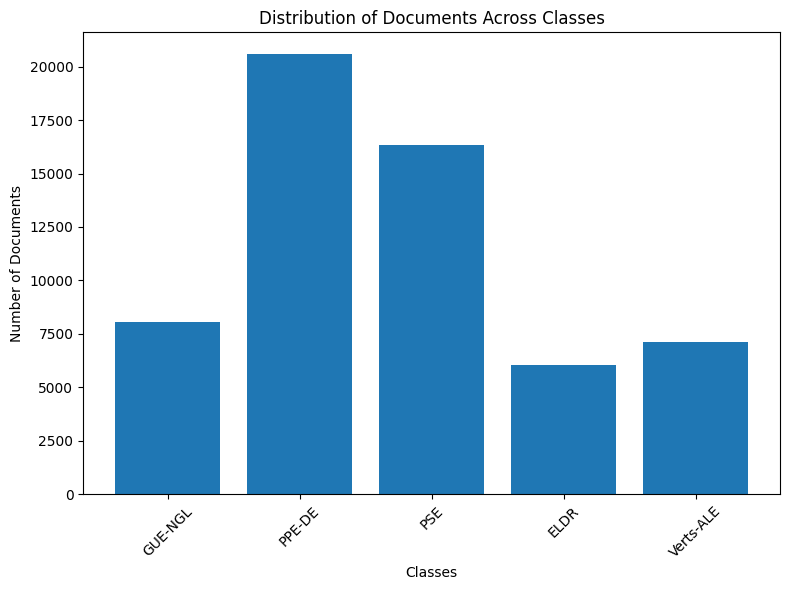

In [9]:
# Distribution of Documents Across Classes

class_counts = {}
for doc_tuple in combined_train_data.values():
    label = doc_tuple[1]  
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1

plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of Documents')
plt.title('Distribution of Documents Across Classes')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()


# Kernal approximation

In [11]:
train_texts, train_labels = zip(*combined_train_data.values())
test_texts, test_labels = zip(*combined_test_data.values())

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('rbf_sampler', RBFSampler(gamma=1, random_state=1)),  # Applying RBFSampler for kernel approximation
    ('clf', SGDClassifier(max_iter=1000)),
])


text_clf.fit(train_texts, train_labels)
test_predictions = text_clf.predict(test_texts)

accuracy = accuracy_score(test_labels, test_predictions)
print(f"Accuracy: {accuracy}")



Accuracy: 0.330417279554076
